In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.special import gamma, binom
from scipy.sparse import diags, kron, block_diag
from scipy.sparse.linalg import spsolve, eigs
from scipy.optimize import fsolve
from scipy.linalg import lstsq
from pathlib import Path
import time
import json
from tqdm.auto import tqdm

import datetime


def compute_classical_energy(u, N, eps, h):
    """Compute the discrete energy :

    Parameters
    ----------
    u : 2D-array
        The numerical solution of u.
    eps : float
        The diffusion coefficient.
    h : float
        The mesh size of x and y direction.
    N : tuple
        The number of grids.

    Returns
    -------
    float
        The discrete energy of u.
        
    """
    if len(N) == 1:
        ux = np.gradient(u)/h
        term1 = np.sum((eps**2 / 2.0) * (ux**2))
        term2 = np.sum(((1 - u ** 2) ** 2) / 4)
    
    elif len(N) == 2:
        u = np.reshape(u, N)
        ux = np.gradient(u, axis = 1)/h
        uy = np.gradient(u, axis = 0)/h
        term1 = np.sum((eps**2 / 2.0) * (ux**2 + uy**2))
        term2 = np.sum(((1 - u ** 2) ** 2) / 4)
    
    return h * (term1 + term2)

def set_coef(terminate_point, alpha, method='L1'):
    """Set the coefficient of fractional scheme:

    Parameters
    ----------
    terminate_point : int
        The number of coefficient.
    alpha : float
        The fractional order between (0,1).
    method : str 
        The coefficient of scheme to generate.
        (defualt is 'L1')
        possible options : 'L1', 'GL'.

    Returns
    -------
    1D array
        The coefficient array generated 
        based on the selected method.
        
    """
    
    if method == 'L1':
        coef = [(j)**(1-alpha) - (j-1)**(1-alpha) \
                for j in range(1, terminate_point+1)]
    elif method == 'GL':
        coef = [(-1)**(j) * binom(alpha, j) \
                for j in range(0, terminate_point+1)]
        
    return np.array(coef)

def set_Laplacian2D(Nx, h, BC='periodic'):
    """Set the 2D discrete laplacian by central difference:
        Neumann boundary laplacian is discreted by 
        
        x-direction : u_{-1,j,k}=u_{0,j,k} and
                      u_{Nx+1,j,k}=u_{0,j,k}
                          
        y-direction : u_{i,-1,k}=u_{i,0,k} and
                      u_{i,Nx+1,k}=u_{i,0,k}
            
        Built by two block matries and two off-diagnoals, 
        corner block (corB), central block (cenB)
            
        The diagonal block is [corB, cenB, ..., cenB, corB]
        The off-diagnoals are diagonals line below (above) 
        the main diagonal by Nx positions, all consisting of 1.
            
        L = diagonal block + off-diagonals

    Parameters
    ----------
    Nx : int
        The number of mesh grids.
    h : float
        The mesh size.
    BC : str
        The boundary condition. (default is 'periodic')
        possible options : 'periodic', 'nuemann'

    Returns
    -------
    2D array
        The discrete laplacian with certain boundary.
        
    """
    if BC == 'periodic':
        diag = np.ones(Nx)
        L = diags([diag, -2*diag, diag, 1, 1], \
                  [-1, 0, 1 , -Nx+1, Nx-1], shape=(Nx, Nx))
        I = diags(diag, shape=(Nx, Nx))
    
        L = kron(L, I) + kron(I, L)
        
    elif BC == 'neumann':
        # bulid the block
        diag_cor = 3*np.ones(Nx)
        diag_cor[0] = diag_cor[-1] = 2

        diag_cen = 4*np.ones(Nx)
        diag_cen[0] = diag_cen[-1] = 3

        off_I = diags([np.ones(Nx**2), np.ones(Nx**2)], \
                      [Nx,-Nx], shape=(Nx**2, Nx**2))

        corB = diags([np.ones(Nx), -diag_cor, np.ones(Nx)], \
                     [-1, 0, 1], shape=(Nx, Nx))

        cenB = diags([np.ones(Nx), -diag_cen, np.ones(Nx)], \
                     [-1, 0, 1], shape=(Nx, Nx))

        diagBs = [cenB for i in range(Nx-2)]
        diagBs = tuple([corB]+diagBs+[corB])

        L = block_diag(diagBs) + off_I
    
        
    return L / h**2


def set_boundary(u, BC):
    if BC == 'neumann':
        # set top, botton, left, right
        u[0, 1:-1] = u[1, 1:-1]
        u[-1, 1:-1] = u[-2, 1:-1]
        u[1:-1, 0] = u[1:-1, 1]
        u[1:-1, -1] = u[1:-1 ,-2]

        # set the corner
        u[0, 0] = u[1, 1]
        u[-1, -1] = u[-2, -2]
        u[-1, 0] = u[-2, 1]
        u[0, -1] = u[1, -2]
        
    return u

In [7]:
set_Laplacian2D(3,1).toarray()

array([[-4.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.],
       [ 1., -4.,  1.,  0.,  1.,  0.,  0.,  1.,  0.],
       [ 1.,  1., -4.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  0., -4.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  1., -4.,  1.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  1.,  1., -4.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.,  0.,  0., -4.,  1.,  1.],
       [ 0.,  1.,  0.,  0.,  1.,  0.,  1., -4.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  1.,  1.,  1., -4.]])

In [391]:
dx = 4 / 100
dt = 2*1e-3
eps = 0.015
dx**2 > dt * 2 * eps

True

8208
8176


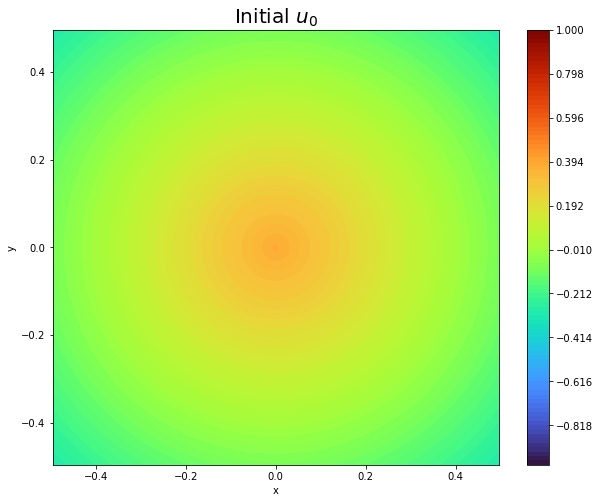

In [76]:
initialName = 'circle'

rootPath = Path('./data/') / initialName

# L1 method
# set the fractional order in list to compute
alpha_list = [0.5]
# alpha_list = [0.1, 0.3, 0.5,  0.7, 0.9, 1]
# boundary condition
BC = 'neumann'

# the width of interface
eps = 0.0001
# eps = 1

# define the saptial domain
# L = 10
L = 1
# determine the number of point in x or y direction
Nx = 128
h = 1 / Nx
x = np.linspace(-L/2+h/2, L/2-h/2, Nx)
y = np.linspace(-L/2+h/2, L/2-h/2, Nx)

# compute the mesh size
dt = 0.05
Nt = 500
# iter_max = 2000

t = np.arange(iter_max+1) * dt

# set the discrete laplacian
Lap = set_Laplacian2D(Nx, h, BC)

if BC == 'periodic':
    x = x[:-1]
    y = y[:-1]
    I = diags(np.ones((Nx-1)**2), shape=((Nx-1)**2, (Nx-1)**2))
elif BC == 'neumann':
    I = diags(np.ones((Nx)**2), shape=((Nx)**2, (Nx)**2))

    
# set the 2D mesh grid by x and y
X, Y = np.meshgrid(x, y)

# set the 2D mesh grid by x and y
x0 = np.linspace(-L/2, L/2, Nx+2)
y0 = np.linspace(-L/2, L/2, Nx+2)
X0, Y0 = np.meshgrid(x0, y0)

R = np.sqrt(L**2/2/np.pi)
central = X**2+Y**2
u0 = np.zeros((Nx+2, Nx+2))
u0 = np.tanh((R-np.sqrt(central)))
# u0 = set_boundary(u0, BC)

print((u0>0).sum())
print((u0<0).sum())

# the dicitionary to storage the different fractional order results
# data_dict = {}

info_dict = {
    'Nx': Nx,
    'dx': dt,
    'iteration': iter_max,
    'boundary': BC,
    'eps': eps
}

plt.figure(figsize=(10,8))
plt.contourf(X,Y, u0, cmap="turbo", levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'Initial $u_0$', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

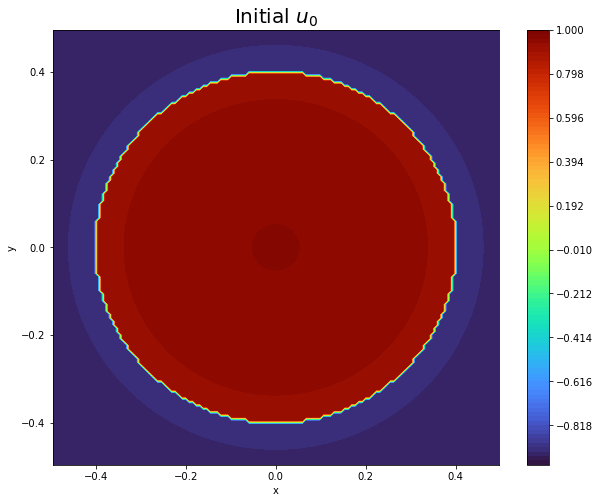

In [78]:
plt.figure(figsize=(10,8))
plt.contourf(X,Y, data_dict[0.5][-1], cmap="turbo", levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'Initial $u_0$', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [14]:
u_historyArray[0].shape

(130, 130)

In [17]:
u_nonlocalDiff

array([], shape=(0, 128, 128), dtype=float64)

alpha: 0.5


  0%|          | 0/500 [00:00<?, ?it/s]

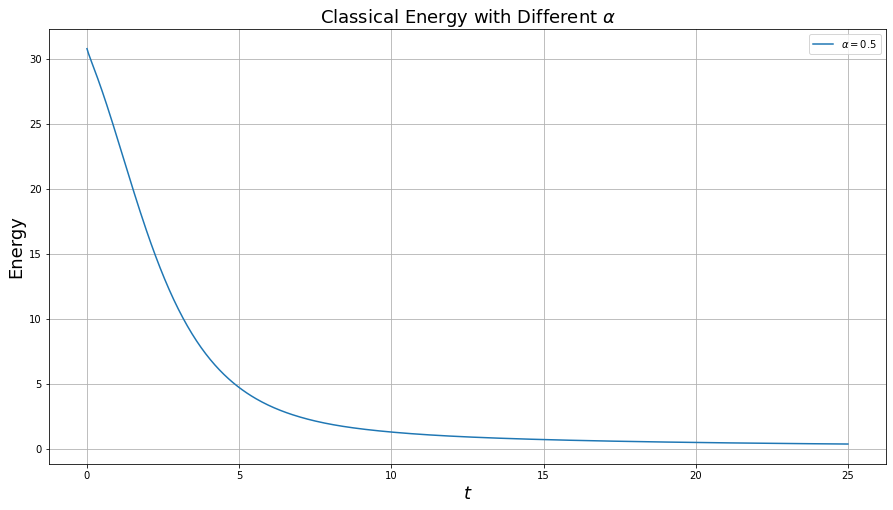

In [77]:
# set a figure to plot the energy in different alpha
fig = plt.figure(figsize=(15,8))
data_dict = {}
# Nx=Nx-1

for alpha in alpha_list:
    print(f"alpha: {alpha}")
    # compute the first energy then store in the list
    energy_list = [compute_classical_energy(u0, (Nx,Nx), eps, h)]
    
    # inital the history array
    u_historyArray = u0.copy().reshape(1, Nx, Nx)
    u = u0.copy()
    
    pbar = tqdm(total=iter_max)
    
    if alpha == 1:
        # solved by classical allen cahn
        H = (2+1/dt) * I - eps**2 * Lap
        
        for i in range(iter_max):
            u_interior = u[1:-1, 1:-1].copy().flatten()
            b = (3+1/dt)*u_interior - u_interior**3
            u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
            u = set_boundary(u, BC)
            energy = compute_classical_energy(u, (Nx+2,Nx+2), eps, h)
            energy_list.append(energy)
            u_historyArray = np.vstack([u_historyArray, u.reshape(1, Nx+2, Nx+2)])
            pbar.update(1)
        
    else:
#         L1_coef = set_coef(iter_max, alpha, 'L1')/ dt**alpha / gamma(2-alpha)
#         H = (L1_coef[0]+2) * I - eps**2 * Lap
        
#         for i in range(iter_max):
#             u_interior = u[1:-1, 1:-1].copy().flatten()
#             if i == 0: # first iteration u_1
#                 b =  (3 + L1_coef[0])*u_interior - u_interior**3
#                 u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
#                 u = set_boundary(u, BC)
#             else:
#                 u_nonlocalDiff = np.flipud(np.diff(u_historyArray[:, 1:-1, 1:-1], axis=0))
#                 u_nonlocal = np.tensordot(L1_coef[1:i+1], u_nonlocalDiff, axes=1)
        
#                 b = (3 + L1_coef[0])*u_interior - u_interior**3 - u_nonlocal.flatten()
#                 u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
#                 u = set_boundary(u, BC)
            
#             energy = compute_classical_energy(u, (Nx+2,Nx+2), eps, h)
#             energy_list.append(energy)
    
#             u_historyArray = np.vstack([u_historyArray, u.reshape(1, Nx+2, Nx+2)])
#             pbar.update(1)
            GL_coef = set_coef(Nt, alpha, 'GL') / dt**alpha
            H = (GL_coef[0]+2) * I - eps**2 * Lap

            for i in range(Nt):
                u_interior = u.copy().flatten()
                if i == 0: # first iteration u_1
                    b =  (3 + GL_coef[0])*u_interior - u_interior**3 
                    u = np.reshape(spsolve(H, b), (Nx, Nx))
#                     u = set_boundary(u, BC)
#                     print(u)
                else:
                    u_nonlocalDiff = np.flipud(u_historyArray[1:]-u0)
                    u_nonlocal = np.tensordot(GL_coef[1:i+1], u_nonlocalDiff, axes=1)
                    b = 3*u_interior - u_interior**3 - u_nonlocal.flatten() + GL_coef[0]*u0.flatten()
                    u = np.reshape(spsolve(H, b), (Nx, Nx))
#                     u = set_boundary(u, BC)

                energy = compute_classical_energy(u, (Nx,Nx), eps, h)
                energy_list.append(energy)
                u_historyArray = np.vstack([u_historyArray, u.reshape(1, Nx, Nx)])
                pbar.update(1)
    
    data_dict[alpha] = u_historyArray
    
    # plot the energy for k=0,...,N_t
    plt.plot(t, energy_list)
    
    pbar.close()
    
plt.legend([r"$\alpha=$"+f"{alpha}" for alpha in alpha_list])
plt.title(r"Classical Energy with Different $\alpha$", fontsize=18)
plt.xlabel("$t$", fontsize=18)
plt.ylabel("Energy", fontsize=18)
plt.grid()
plt.show()

In [34]:
dt = 15/3000
idx_time_points * dt
# h = 1/128

array([ 0.   ,  0.305,  0.61 ,  0.915,  1.22 ,  1.53 ,  1.835,  2.14 ,
        2.445,  2.755,  3.06 ,  3.365,  3.67 ,  3.975,  4.285,  4.59 ,
        4.895,  5.2  ,  5.51 ,  5.815,  6.12 ,  6.425,  6.73 ,  7.04 ,
        7.345,  7.65 ,  7.955,  8.265,  8.57 ,  8.875,  9.18 ,  9.485,
        9.795, 10.1  , 10.405, 10.71 , 11.02 , 11.325, 11.63 , 11.935,
       12.24 , 12.55 , 12.855, 13.16 , 13.465, 13.775, 14.08 , 14.385,
       14.69 , 15.   ])

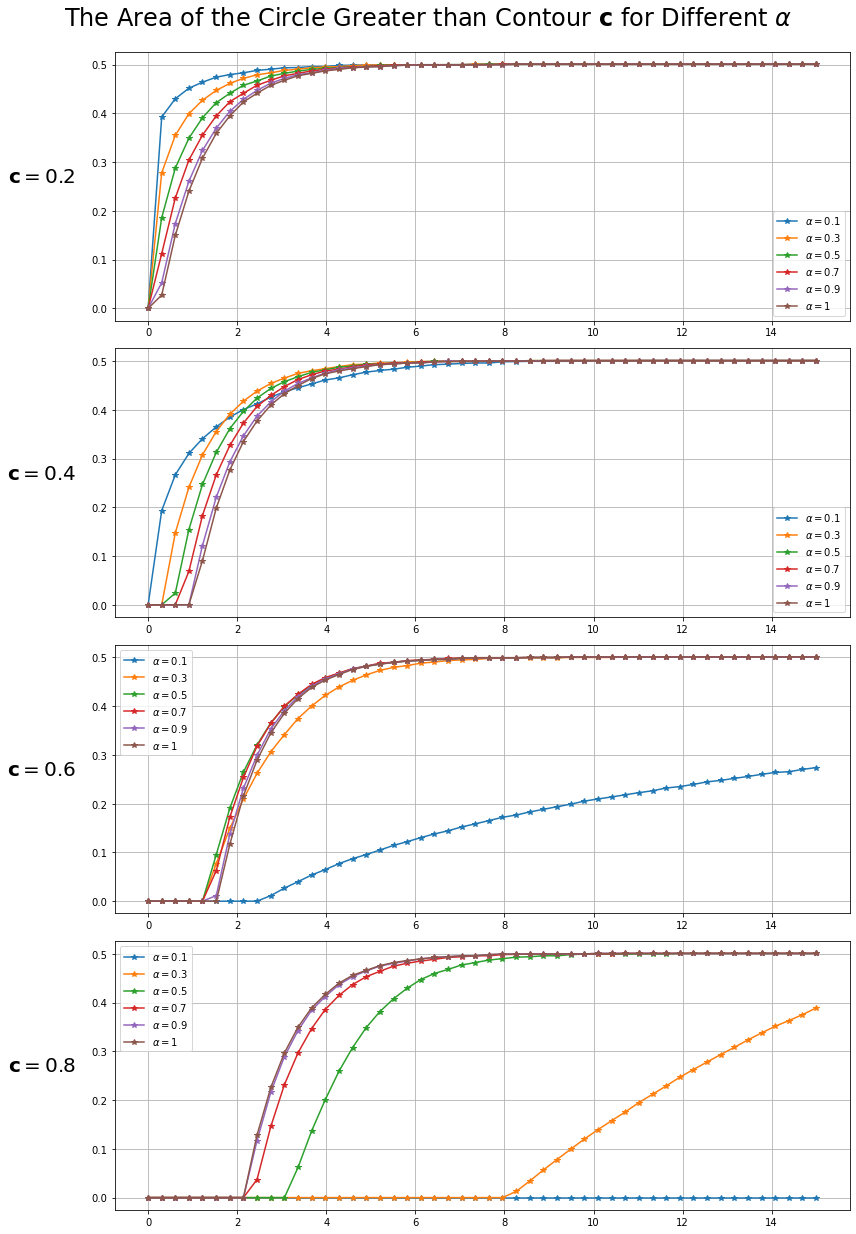

In [32]:
circle_dict = {}

idx_time_points = np.linspace(0, 3000, 50, dtype = int)
levels = [0.2, 0.4, 0.6, 0.8]
# levels=[0.05]
# levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 

fig, ax = plt.subplots(len(levels), 1, figsize=(12, 18))
i = 0 
for level in levels:
    circle_dict = {}
    for alpha in alpha_list:
        area_list = []
        for idx_time in idx_time_points:
            points = (data_dict[alpha][idx_time] > level).sum()
            if points != 0:
                area = points*h**2
            else:
                area = 0
            area_list.append(area)
        circle_dict[alpha] = area_list


    t = [_*dt for _ in idx_time_points]
    
    for alpha, area in circle_dict.items():
        ax[i].plot(t, area, '*-')


    ax[i].legend([rf"$\alpha=${alpha}" for alpha in alpha_list])
#     ax[i].set_xlabel('T')
    ax[i].grid()
    ax[i].set_ylabel(r'$\mathbf{c}=$'+f'{level}', fontsize=20, rotation=0, labelpad=50)
#     ax[i].set_title(fr'Area of the Circle in Different $\alpha$ at level is large than {level}')
    i += 1

fig.suptitle(r'The Area of the Circle Greater than Contour $\mathbf{c}$ for Different $\alpha$', fontsize=24)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [31]:
import time
ts = str(time.time())
rootPath = Path('./data/') / initialName / ts
# rootPath = rootPath / ts

if rootPath.exists() is False:
    rootPath.mkdir(parents=True)
    
pbar = tqdm(total=len(alpha_list))
for alpha, u_historyArray in data_dict.items():
    
    dataPath = rootPath / f'L1_{alpha}_circle.npy'
    np.save(dataPath, u_historyArray)
    pbar.update(1)
    
pbar.close()
infoPath = rootPath / 'info.json'
infoPath.write_text(json.dumps(info_dict))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.98s/it]


81

In [18]:
data_dict[1].shape

(3001, 130, 130)

In [6]:
# load data
initialName = 'circle'

rootPath = Path('./data/') / initialName 

dataPath = [folder for folder in rootPath.iterdir() \
            if not folder.name[0].startswith('.')]

alpha_list = [0.1 , 0.3 , 0.5, 0.7, 0.9, 1]

for folder in dataPath:
    data_dict = {}
    for alpha in alpha_list:
        u_hist = np.load(folder / f'L1_{alpha}_{initialName}.npy')
        data_dict[alpha] = u_hist

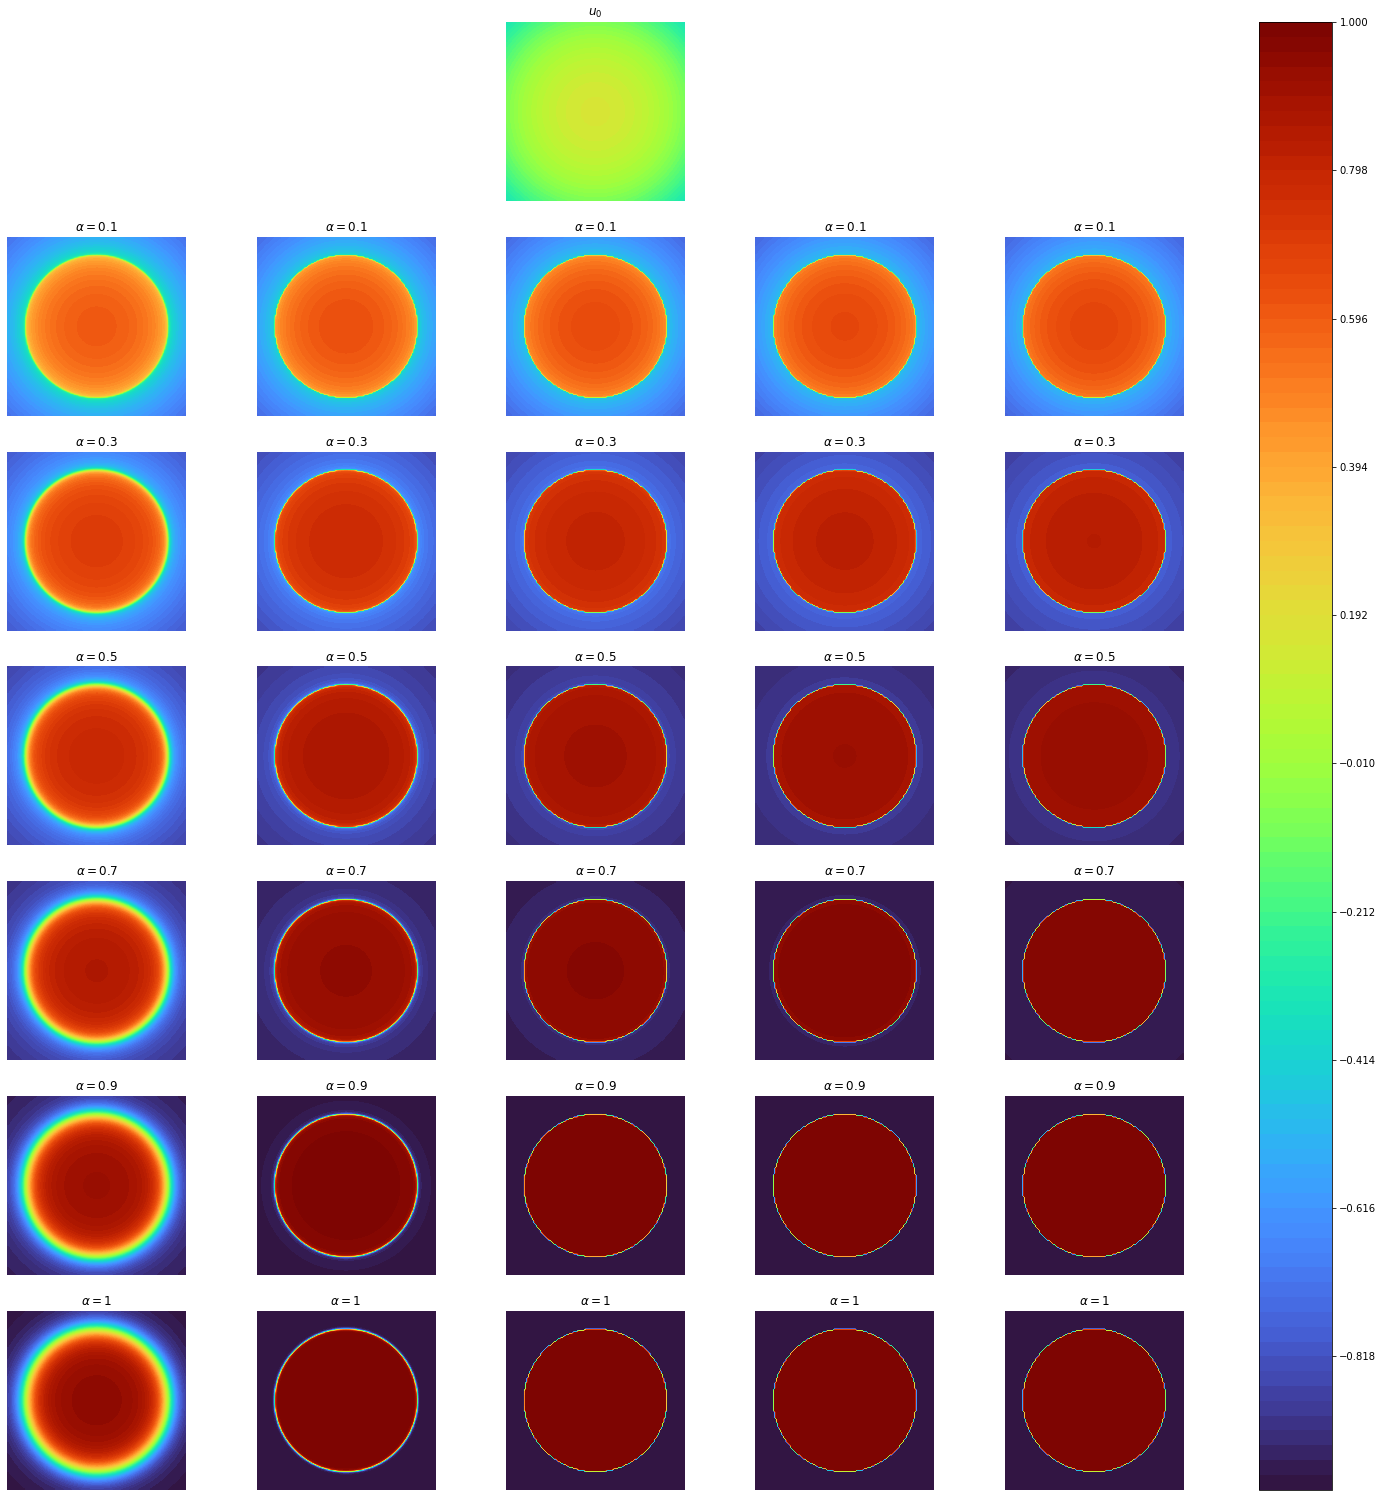

In [79]:
fig, ax = plt.subplots(len(alpha_list)+1, 5,figsize=(27, 27))
# ax[0,2].set_title("Initial Data")
contour = ax[0,2].contourf(X0,Y0,data_dict[1][0] , cmap="turbo", levels=np.linspace(-1,1,100))
ax[0,2].set_aspect('equal', 'box')
ax[0,2].axis('off')
ax[0,2].set_title(r'$u_0$')
fig.colorbar(contour, ax=ax, location='right')

t_idx = [600, 1200, 1800, 2400, 3000]

for j, alpha in enumerate(alpha_list):
    for i,t in enumerate(t_idx):
        contour=ax[j+1,i].contourf(X0, Y0, data_dict[alpha][t] , cmap="turbo", levels=np.linspace(-1,1,100))
        ax[j+1,i].set_aspect('equal', 'box')
        ax[j+1,i].axis('off')
        ax[j+1,i].set_title(fr'$\alpha={alpha}$')

ax[0, 0].remove()
ax[0, 1].remove()
ax[0, 3].remove()
ax[0, 4].remove()
# plt.tight_layout()
# axs[0,2].axis('off')
# axs[0,2].set_aspect('equal', 'box')

# plt.contourf(X0,Y0, u0, cmap="turbo", levels=np.linspace(-1,1,100))
# plt.colorbar()

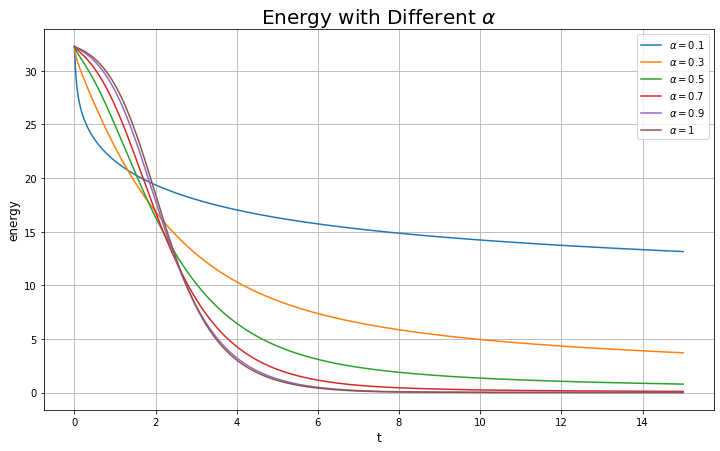

In [33]:
energy_dict = {}
Nx = 128
eps = 0.0001
h = 1/Nx
t = np.arange(3000+1) * 0.005
alpha_list = []

plt.figure(figsize=(12,7))
for alpha, u_hist in data_dict.items():
    energy_list = []
    for u in u_hist:
        energy = compute_classical_energy(u, (Nx+2,Nx+2), eps, h)
        energy_list.append(energy)
    alpha_list.append(alpha)
    energy_dict[alpha] = energy_list
    plt.plot(t, energy_list)

plt.legend([rf"$\alpha=${alpha}" for alpha in alpha_list])
plt.title(r'Energy with Different $\alpha$', fontsize=20)
plt.xlabel('t',fontsize=12)
plt.ylabel('energy',fontsize=12)
plt.grid()
plt.show()

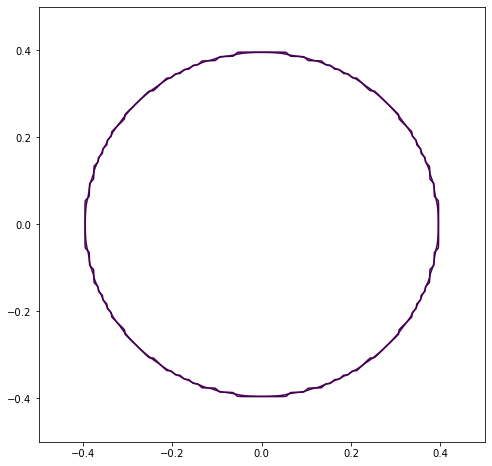

In [24]:
# define the saptial domain
# L = 10
L = 1
# determine the number of point in x or y direction
Nx = 100
h = L / Nx
x = np.linspace(-L/2+h/2, L/2-h/2, Nx)
y = np.linspace(-L/2+h/2, L/2-h/2, Nx)


# set the 2D mesh grid by x and y
X, Y = np.meshgrid(x, y)

# set the 2D mesh grid by x and y
x0 = np.linspace(-L/2, L/2, Nx+2)
y0 = np.linspace(-L/2, L/2, Nx+2)
X0, Y0 = np.meshgrid(x0, y0)

# Z = np.tanh((0.4-(np.sqrt((X0)**2+(Y0)**2)))/np.sqrt(2)/0.015)
plt.figure(figsize=(8,8))
# CS = plt.contour(X0, Y0, data_dict[1][800],[0.0])
# CS = plt.contour(X0, Y0, data_dict[0.9][800],[0.0])
# CS = plt.contour(X0, Y0, data_dict[0.7][800],[0.0])
# CS = plt.contour(X0, Y0, data_dict[0.5][800],[0.0])
# CS = plt.contour(X0, Y0, data_dict[0.3][800],[0.0])
CS = plt.contour(X0, Y0, data_dict[0.1][-1],[0.0])
# plt.clabel(CS, inline=1, fontsize=10)
CS = plt.contour(X0, Y0, data_dict[1][0],[0.0])
# plt.clabel(CS, inline=1, fontsize=10)
plt.show()

In [370]:
data_dict[0.1][1]

KeyError: 0.1

In [304]:
def rad(r0, t, alpha):
    if alpha == 1:
        coef = 2
    else:
        coef = gamma(1-alpha/2)/gamma(1+alpha/2)
    return np.sqrt(r0**2 - coef*t**alpha)

In [345]:
def upper_bound_t(r0, alpha):
    return (r0**2*gamma(1+alpha/2)/gamma(1-alpha/2))**(1/alpha)

In [346]:
upper_bound_t(r0, alpha)

6.167123501896984e-09

In [337]:
(gamma(1+0.1/2)/gamma(1-0.1/2))**(1-0.1)

0.9492911973035891

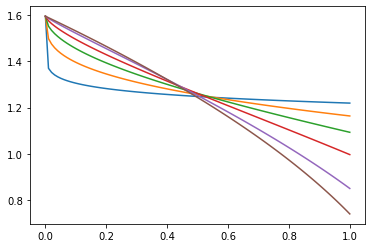

In [404]:
# r0 = 1.5
for alpha in alpha_list:
    tt = np.linspace(0, 1, num=100)
    plt.plot(tt, rad(R, tt, alpha), '-')

In [252]:
data_dict[1][-1][24,5:47]

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -0.99999998, -0.99999987, -0.99999929, -0.99999609,
       -0.99997863, -0.9998831 , -0.99936072, -0.99650734, -0.98099639,
       -0.89864322, -0.51228928,  0.41358578,  0.83311858,  0.94764287,
        0.9751521 ,  0.9751521 ,  0.94764287,  0.83311858,  0.41358578,
       -0.51228928, -0.89864322, -0.98099639, -0.99650734, -0.99936072,
       -0.9998831 , -0.99997863, -0.99999609, -0.99999929, -0.99999987,
       -0.99999998, -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        ])

In [238]:
R

0.3989422804014327

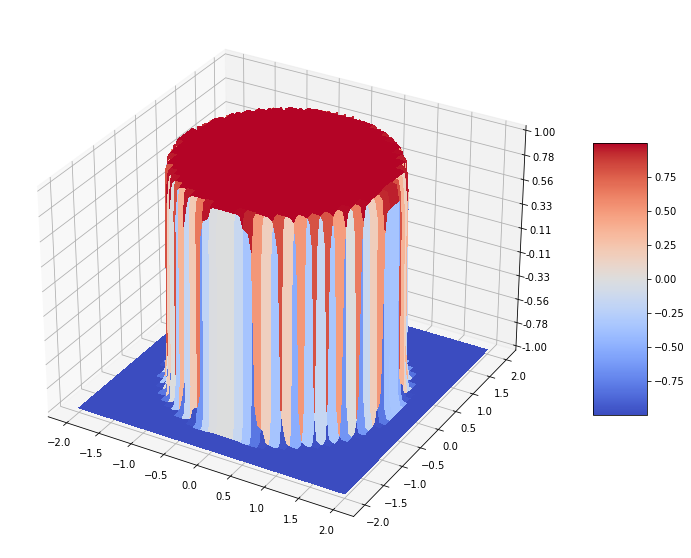

In [20]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(figsize=(15,10),subplot_kw={"projection": "3d"})
Z = np.reshape(data_dict[0.1][-1], (Nx+2,Nx+2))
# Z = np.tanh((0.4-(np.sqrt((X0)**2+(Y0)**2))))


# Plot the surface.
surf = ax.plot_surface(X0, Y0, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

alpha: 0.1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 20.96it/s]


alpha: 0.3


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.54it/s]


alpha: 0.5


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.11it/s]


alpha: 0.7


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.34it/s]


alpha: 0.9


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.33it/s]


alpha: 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.14it/s]


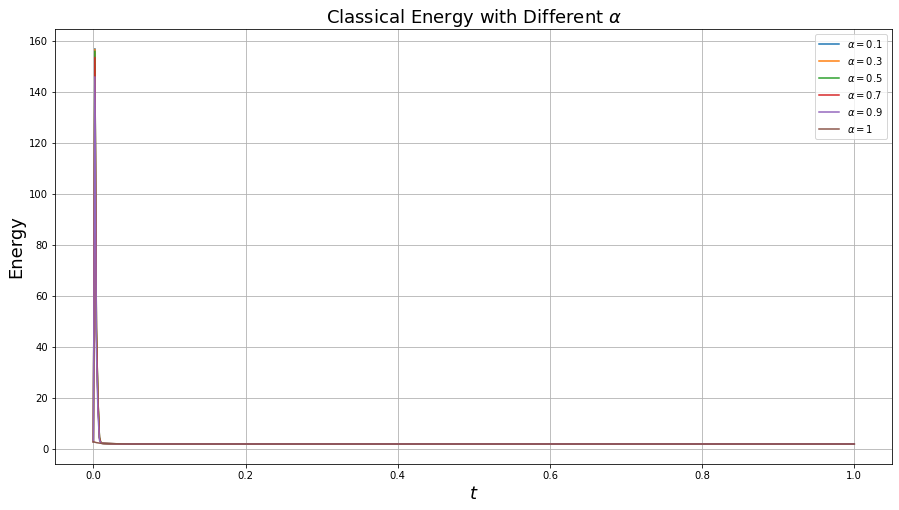

In [6]:
# set a figure to plot the energy in different alpha
fig = plt.figure(figsize=(15,8))

# Nx=Nx-1

for alpha in alpha_list:
    print(f"alpha: {alpha}")
    # compute the first energy then store in the list
    energy_list = [compute_classical_energy(u0, (Nx+2,Nx+2), eps, h)]
    
    # inital the history array
    u_historyArray = u0.copy().reshape(1, Nx+2, Nx+2)
    u = u0.copy()
    
    pbar = tqdm(total=iter_max)
    
    if alpha == 1:
        # solved by classical allen cahn
        H = (2/eps**2+1/dt) * I - Lap
        
        for i in range(iter_max):
            u_interior = u[1:-1, 1:-1].copy().flatten()
            b = (3/eps**2+1/dt)*u_interior - u_interior**3/eps**2
            u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
            u = set_boundary(u, BC)
            energy = compute_classical_energy(u, (Nx+2,Nx+2), eps, h)
            energy_list.append(energy)
            u_historyArray = np.vstack([u_historyArray, u.reshape(1, Nx+2, Nx+2)])
            pbar.update(1)
        
    else:
        L1_coef = set_coef(iter_max, alpha, 'L1')/ dt**alpha / gamma(2-alpha)
        H = (L1_coef[0]+2/eps**2) * I - Lap
        
        for i in range(iter_max):
            u_interior = u[1:-1, 1:-1].copy().flatten()
            if i == 0: # first iteration u_1
                b =  (3/eps**2 + L1_coef[0])*u_interior - u_interior**3
                u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
                u = set_boundary(u, BC)
            else:
                u_nonlocalDiff = np.flipud(np.diff(u_historyArray[:, 1:-1, 1:-1], axis=0))
                u_nonlocal = np.tensordot(L1_coef[1:i+1], u_nonlocalDiff, axes=1)
        
                b = (3/eps**2 + L1_coef[0])*u_interior - u_interior**3/eps**2 - u_nonlocal.flatten()
                u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
                u = set_boundary(u, BC)
            
            energy = compute_classical_energy(u, (Nx+2,Nx+2), eps, h)
            energy_list.append(energy)
    
            u_historyArray = np.vstack([u_historyArray, u.reshape(1, Nx+2, Nx+2)])
            pbar.update(1)
    
    
    data_dict[alpha] = u_historyArray
    
    # plot the energy for k=0,...,N_t
    plt.plot(t, energy_list)
    
    pbar.close()
    
plt.legend([r"$\alpha=$"+f"{alpha}" for alpha in alpha_list])
plt.title(r"Classical Energy with Different $\alpha$", fontsize=18)
plt.xlabel("$t$", fontsize=18)
plt.ylabel("Energy", fontsize=18)
plt.grid()
plt.show()

In [14]:
data_dict[0.1][1][20:80]

array([[-1.49977867, -1.49977867, -1.49977867, ..., -1.49977867,
        -1.49977867, -1.49977867],
       [-1.49977867, -1.49977867, -1.49977867, ..., -1.49977867,
        -1.49977867, -1.49977867],
       [-1.49977867, -1.49977867, -1.49977867, ..., -1.49977867,
        -1.49977867, -1.49977867],
       ...,
       [-1.49977867, -1.49977867, -1.49977867, ..., -1.49977867,
        -1.49977867, -1.49977867],
       [-1.49977867, -1.49977867, -1.49977867, ..., -1.49977867,
        -1.49977867, -1.49977867],
       [-1.49977867, -1.49977867, -1.49977867, ..., -1.49977867,
        -1.49977867, -1.49977867]])